# Battery Cell Quality Prediction

This notebook **aims** to build a battery **Pass/Fail** predictor from real or synthetic manufacturing data, showcasing PCA + ML, grouped splits by batch, robust metrics, and stakeholder visuals.

**Key highlights:**
- Grouped train/val/test split by `batch_id`
- `Pipeline`: scaling → PCA (retain 95% variance) → RandomForest
- ROC-AUC, PR-AUC, confusion, and threshold tuning
- Feature importance and batch yield plots



In [4]:

# Core imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import joblib, os
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True
print("Imports ready.")


Imports ready.


## 1) Data: load the dataset
Synthetic Data for Prototyping purposes (Real cell data soon)


In [5]:
# Use the notebook's current working directory
base_dir = Path.cwd()  # Current working directory
file_path = base_dir / "data" / "synthetic_cells.csv"

df = pd.read_csv(file_path)
print(df.head())

   batch_id  coat_thickness    dry_temp   cal_press  slurry_visc  dcir_mOhm  \
0         1       74.878197  104.797394  226.776532   892.144965  34.768070   
1         8       76.310019  110.318532  210.708222   996.382689  33.628588   
2         7       84.457782  102.838413  205.158828   879.147334  26.418212   
3         5       86.867344  108.834824  205.755589   902.313187  37.142821   
4         5       78.172753   98.864449  218.395377  1021.755039  36.913853   

   capacity_Ah  volt_drift_V   leak_uA  label_pass  
0     5.058499     -0.021757  9.123902           1  
1     4.841145      0.010676  6.818358           0  
2     4.963913     -0.014057  4.987968           1  
3     5.301824      0.000524  8.040925           1  
4     4.936085     -0.002456  5.084469           1  


## 2) Exploratory Data Analysis
Look at distributions and pass rate per batch.

In [6]:

df.describe(include="all")


,batch_id,coat_thickness,dry_temp,cal_press,slurry_visc,dcir_mOhm,capacity_Ah,volt_drift_V,leak_uA,label_pass
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5.453875,79.757388,109.692948,200.292513,949.794165,34.912608,4.998100,-0.000229,8.007558,0.719875
std,2.872090,3.237154,5.498779,10.017977,60.188623,3.030252,0.161525,0.015220,2.041748,0.449088
min,1.000000,66.832656,90.513162,164.695909,694.579443,23.419369,4.258637,-0.054330,0.587738,0.000000
25%,3.000000,77.607979,105.998857,193.571115,909.040579,32.912367,4.889609,-0.010561,6.640955,0.000000
50%,5.000000,79.762688,109.640037,200.334390,949.656818,34.901833,4.997638,-0.000255,8.004274,1.000000
75%,8.000000,81.876864,113.430138,206.904670,990.526541,36.946794,5.105510,0.009872,9.383879,1.000000
max,10.000000,93.277472,128.401215,236.825095,1195.275384,50.015640,5.642728,0.065116,15.341965,1.000000


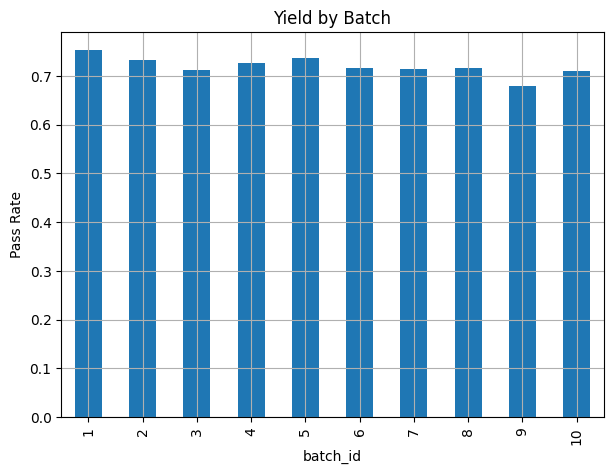

In [7]:

batch_yield = df.groupby("batch_id")["label_pass"].mean().sort_index()
batch_yield.plot(kind="bar")
plt.ylabel("Pass Rate")
plt.title("Yield by Batch")
plt.show()


## 3) Train/Val/Test split: **by batch_id** to avoid data leakage

In [8]:

X = df.drop(columns=["label_pass"])
y = df["label_pass"].values
groups = df["batch_id"].values

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=7)
train_idx, temp_idx = next(gss.split(X, y, groups))

X_train, y_train, g_train = X.iloc[train_idx], y[train_idx], groups[train_idx]

gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=7)
val_idx, test_idx = next(gss2.split(X.iloc[temp_idx], y[temp_idx], groups[temp_idx]))
val_idx, test_idx = temp_idx[val_idx], temp_idx[test_idx]

X_val, y_val = X.iloc[val_idx], y[val_idx]
X_test, y_test = X.iloc[test_idx], y[test_idx]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (5611, 9) (800, 9) (1589, 9)


## 4) Baseline model: Pipeline(Scale - PCA - RandomForest)

In [9]:

numeric = X.columns.tolist()

pre = ColumnTransformer([
    ("scale", StandardScaler(), numeric),
], remainder="drop")

base_model = Pipeline([
    ("pre", pre),
    ("pca", PCA(n_components=0.95, svd_solver="full")),
    ("rf", RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight="balanced_subsample", random_state=7
    ))
])

base_model.fit(X_train, y_train)
proba_val = base_model.predict_proba(X_val)[:,1]
print("Val ROC-AUC:", round(roc_auc_score(y_val, proba_val), 4))
print("Val PR-AUC :", round(average_precision_score(y_val, proba_val), 4))


Val ROC-AUC: 0.9056
Val PR-AUC : 0.9509


## 5) GridSearchCV Tuning

In [10]:

param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 3, 5]
}
gs = GridSearchCV(base_model, param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
best = gs.best_estimator_
print("Best params:", gs.best_params_)

# Validate
proba_val = best.predict_proba(X_val)[:,1]
print("Val ROC-AUC:", round(roc_auc_score(y_val, proba_val), 4))
print("Val PR-AUC :", round(average_precision_score(y_val, proba_val), 4))


Best params: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 400}
Val ROC-AUC: 0.9074
Val PR-AUC : 0.952


## 6) Final evaluation on Test set + curves + confusion

              precision    recall  f1-score   support

           0      0.920     0.724     0.811       479
           1      0.891     0.973     0.930      1110

    accuracy                          0.898      1589
   macro avg      0.906     0.849     0.870      1589
weighted avg      0.900     0.898     0.894      1589

Test ROC-AUC: 0.9435
Test PR-AUC : 0.9613
Confusion:
 [[ 347  132]
 [  30 1080]]


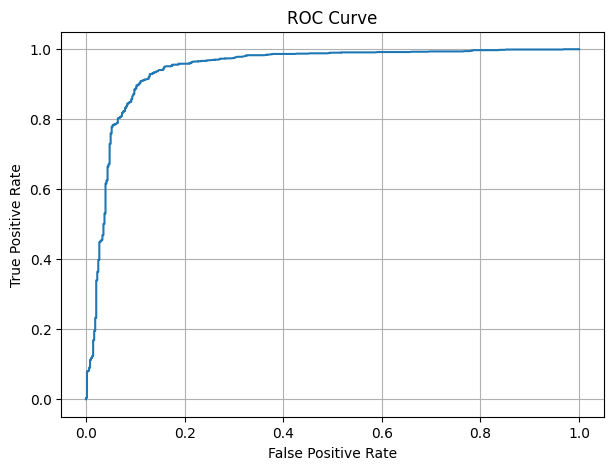

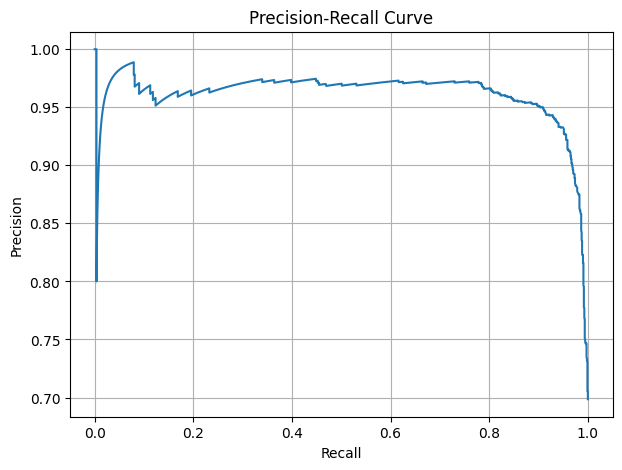

In [11]:

proba_test = best.predict_proba(X_test)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test, digits=3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, proba_test), 4))
print("Test PR-AUC :", round(average_precision_score(y_test, proba_test), 4))
print("Confusion:\n", confusion_matrix(y_test, pred_test))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


## 7) Threshold tuning: select operating point to minimize false passes

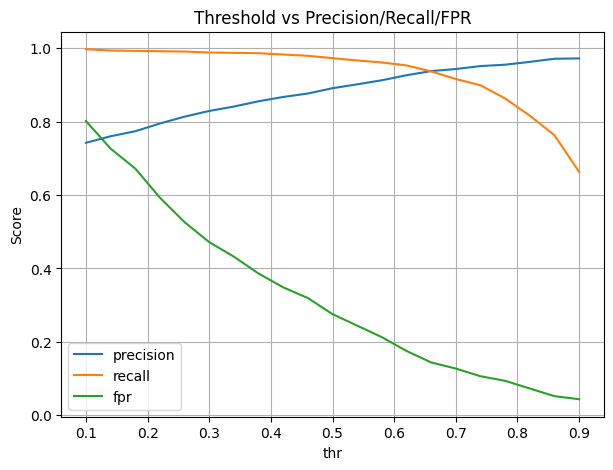

,thr,recall,precision,fpr
17,0.78,0.863063,0.955135,0.093946


In [12]:

# Example: choose threshold that keeps false positive rate under a target
targets = np.linspace(0.1, 0.9, 21)
from collections import defaultdict
stats = defaultdict(list)
for t in targets:
    pred = (proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    recall = tp / (tp+fn) if (tp+fn)>0 else 0.0
    precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
    fpr = fp / (fp+tn) if (fp+tn)>0 else 0.0
    stats["thr"].append(t); stats["recall"].append(recall); stats["precision"].append(precision); stats["fpr"].append(fpr)

stats = pd.DataFrame(stats)
ax = stats.plot(x="thr", y=["precision","recall","fpr"])
ax.set_ylabel("Score"); ax.set_title("Threshold vs Precision/Recall/FPR")
plt.show()

# Pick threshold with FPR <= 0.1 as an example
cand = stats[stats["fpr"]<=0.1].sort_values("recall", ascending=False).head(1)
cand


## 8) Explainability: permutation importance (top features)

In [13]:

r = permutation_importance(best, X_val, y_val, n_repeats=10, random_state=7)
imp = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
imp.head(10)


capacity_Ah       0.181875
dcir_mOhm         0.085125
leak_uA           0.018875
slurry_visc       0.006875
dry_temp          0.004000
volt_drift_V      0.003375
coat_thickness    0.001375
cal_press         0.000125
batch_id          0.000000
dtype: float64

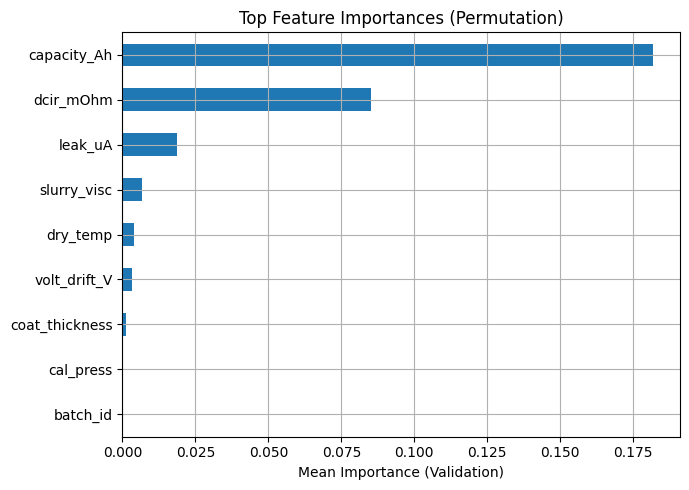

In [14]:

imp.sort_values().tail(12).plot(kind="barh")
plt.title("Top Feature Importances (Permutation)")
plt.xlabel("Mean Importance (Validation)")
plt.tight_layout(); plt.show()


## 9) Save model + simple scoring function

In [15]:

os.makedirs("models", exist_ok=True)
joblib.dump(best, "models/quality_model.joblib")
print("Saved to models/quality_model.joblib")

def score_new_cells(df_new):
    mdl = joblib.load("models/quality_model.joblib")
    return mdl.predict_proba(df_new)[:,1]

# Demo on first 5 rows of test
demo_scores = score_new_cells(X_test.head(5))
pd.Series(demo_scores, name="fail_probability").to_frame()


Saved to models/quality_model.joblib


,fail_probability
0,0.875000
1,0.982041
2,0.982016
3,0.986948
4,0.327500
